In [139]:
import pandas as pd
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import griddata
import os
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

file = r"Combined_Pointcloud.ply"
pcd = o3d.io.read_point_cloud(file, format="ply") #<-- Must be changed when using .ply file
# Multiply the z values by -1
points = np.asarray(pcd.points)
points[:, 2] *= -1  # Negate the z values
# Update the point cloud with the modified points
pcd.points = o3d.utility.Vector3dVector(points)

#Downsampling for more lightweight
downpcd = pcd.voxel_down_sample(voxel_size=0.8)

#3D visulization and downscaling (circles)
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red), and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 1])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

print("Statistical outlier removal")
cl, ind = downpcd.remove_statistical_outlier(nb_neighbors=20,
                                             std_ratio=5)

visualized = o3d.visualization.draw_geometries([cl]) # Display 3D without Outliers

#display_inlier_outlier(downpcd,ind) # Display Outliers

Statistical outlier removal


Points shape: (16949, 3)
Colors shape: (16949, 3)


C:\Users\victo\AppData\Local\Temp\ipykernel_28372\1731037337.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Complete_data = pd.concat([Complete_data, group_combined[['x', 'y', 'z', 'r', 'g', 'b', 'Slope', 'Angle', 'Curvature']]], ignore_index=True)


               x      y          z         r         g         b     Slope  \
0      10.543948    0.0 -35.906814  0.618873  0.618873  0.618873       NaN   
1      11.353135    0.0 -35.904006  0.630219  0.630219  0.630219 -0.041954   
2      12.162322    0.0 -35.898007  0.604902  0.604902  0.604902  0.052623   
3      12.946988    0.0 -35.901416  0.752941  0.752941  0.752941 -0.017017   
4      13.756175    0.0 -35.894916  0.721799  0.721799  0.721799  0.029491   
...          ...    ...        ...       ...       ...       ...       ...   
29224  35.309973  156.0 -35.729866  0.264146  0.264146  0.264146 -0.088564   
29225  35.702306  156.0 -35.809087  0.243137  0.243137  0.243137  0.004404   
29226  36.127333  156.0 -35.759465  0.216340  0.216340  0.216340 -0.096775   
29227  36.192722  156.0 -35.804541  0.186275  0.186275  0.186275  0.073048   
29228  36.609576  156.0 -35.724238  0.215686  0.215686  0.215686       NaN   

          Angle  Curvature  
0           NaN        NaN  
1    

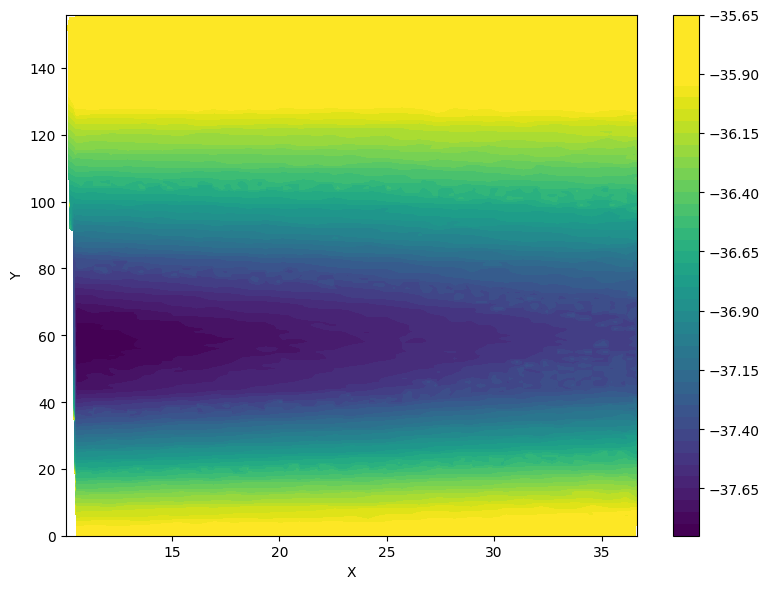

Minimum z-value: -37.84289331250001
Maximum z-value: -35.659621529411766
Minimum x-value: 10.0535315
Maximum x-value: 36.658617
Color Range - Min: -37.8155, Max: -35.9363


In [141]:
################################################################
##              DEFINE PARAMETERS OF DATASET                  ##
################################################################

# Define the x-value range you want to focus on
x_min = 10  # Minimum x-value
x_max = 50  # Maximum x-value

# Define optional manual color range (set to None to use automatic scaling)
z_color_min =  -38 # Minimum z-value for color scaling
z_color_max = -45  # Maximum z-value for color scaling

points = np.asarray(cl.points)
colors = np.asarray(cl.colors)

print(f"Points shape: {points.shape}")
print(f"Colors shape: {colors.shape}")

# Convert to DataFrame
df = pd.DataFrame(
    np.hstack((points, colors)),  # Combine points and colors horizontally
    columns=['x', 'y', 'z', 'r', 'g', 'b']  # Column names for points and colors
)
# Sort Values
df = df.sort_values(by=['y', 'x']).reset_index(drop=True)

# Round y values to 2 decimal places
df['y'] = df['y'].round(1)

# Filter the DataFrame to only include x-values within the specified range
df = df[(df['x'] >= x_min) & (df['x'] <= x_max)]

# Get unique y values
unique_y_values = sorted(df['y'].unique())

# Group the DataFrame by the filtered y values
groups = df.groupby('y')

# Initialize the DataFrame for combined results
Complete_data = pd.DataFrame(columns=['x', 'y', 'z', 'r', 'g', 'b', 'Slope', 'Angle', 'Curvature'])
group_list = list(groups)
list_amount = len(group_list)

# Information that doesn't change
step_size = 5  # Central difference method with increased step size

# Processing loop
for k in range(2, list_amount-2, 1):
    # Combine multiple groups together
    group_combined = pd.concat([group_list[k-2][1], group_list[k-1][1], group_list[k][1], group_list[k+1][1], group_list[k+2][1]])
    group_combined = group_combined.sort_values(by='x').reset_index(drop=True)
    z = group_combined['z']

    # Finite Central difference to find the slope
    slopes = []
    for i in range(step_size, len(z) - step_size):
        slope_current = (z[i+step_size] - z[i-step_size]) / (group_combined['x'][i+step_size] - group_combined['x'][i-step_size])
        slopes.append(slope_current)

    Angles = np.rad2deg(np.arctan(slopes))  # Angles at every step

    # Finite Central difference to find the curvatures
    Curvatures = []
    for i in range(step_size, len(slopes) - step_size):
        Curvature_current = (slopes[i+step_size] - slopes[i-step_size]) / (group_combined['x'][i+step_size] - group_combined['x'][i-step_size])
        Curvatures.append(Curvature_current)

    # Ensure the NaN padding matches the length of the final data
    # Create NaN padding for both slopes and angles
    nan_padding = [np.nan] * step_size

    # Calculate the total length of NaN padding + smoothed slopes
    padded_slopes = nan_padding + slopes + nan_padding
    padded_angles = nan_padding + Angles.tolist() + nan_padding
    padded_curvatures = nan_padding*2 + Curvatures + nan_padding*2

    # Make sure padded data matches the length of group_combined
    if len(padded_slopes) == len(group_combined) and len(padded_curvatures) == len(group_combined):
        group_combined['Slope'] = padded_slopes
        group_combined['Angle'] = padded_angles
        group_combined['Curvature'] = padded_curvatures
        group_combined['z'] = z  # Reassign smoothed z-values

        # Append the processed data directly to the DataFrame
        Complete_data = pd.concat([Complete_data, group_combined[['x', 'y', 'z', 'r', 'g', 'b', 'Slope', 'Angle', 'Curvature']]], ignore_index=True)
    else:
        print(f"Length mismatch: group_combined={len(group_combined)}, padded_slopes={len(padded_slopes)}, padded_curvatures={len(padded_curvatures)}")

# Sort the final DataFrame
Complete_data = Complete_data.sort_values(by=['y', 'x']).reset_index(drop=True)
print(Complete_data)

# Plotting
if True == True:
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))  # Single plot

    # Create a grid for contour plotting, ensuring x and y are on a regular grid
    X, Y = np.meshgrid(np.sort(np.unique(Complete_data['x'])), np.sort(np.unique(Complete_data['y'])))

    # Plot for X,Y,Z
    Z = griddata((Complete_data['x'], Complete_data['y']), Complete_data['z'], (X, Y), method='linear')
    
    # Get the actual minimum and maximum z-values
    z_min = Complete_data['z'].min()
    z_max = Complete_data['z'].max()

    # Set the color range manually, ensuring min is less than or equal to max
    z_color_min = -37.8155
    z_color_max = -35.9363

    # Create contour plot with manual color range
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=z_color_min, vmax=z_color_max)
    fig.colorbar(contour, ax=ax)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Get minimum and maximum z-values
    min_z = Complete_data['z'].min()
    max_z = Complete_data['z'].max()

    
    # Get minimum and maximum z-values
    min_x = Complete_data['x'].min()
    max_x = Complete_data['x'].max()



    print(f"Minimum z-value: {min_z}")
    print(f"Maximum z-value: {max_z}")
    print(f"Minimum x-value: {min_x}")
    print(f"Maximum x-value: {max_x}")
    print(f"Color Range - Min: {z_color_min}, Max: {z_color_max}")